In [1]:
import tensorflow as tf
from tensorflow_probability import distributions as tfd
import tensorflow_probability as tfp
import tensorflow.keras.backend as K
import math as m
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sigma_z_prior = 1
pi = np.pi

Dávid által módosított generate_data() függvény kis változtatásokkal:

In [3]:
def generate_data(N=100, alpha=0, z_prior_type='uniform', sigma_z_prior=1, r_bias=0, sigma_reward=0.1, sigma_bias=0, reward_slope = 1):
  gamma = reward_slope * np.array([tf.cos(tf.cast(alpha/180*pi,tf.float32)), tf.sin(tf.cast(alpha/180*pi,tf.float32))])

  if z_prior_type == 'normal':
      z_prior = tfd.MultivariateNormalDiag(loc=[0,0], scale_diag=[sigma_z_prior,sigma_z_prior]);
  elif z_prior_type == 'uniform':
      z_prior = tfd.Uniform([0,0],[sigma_z_prior,sigma_z_prior])

  z = np.array(z_prior.sample(N))

  r_noise = tfd.Normal(0, sigma_reward).sample(N)
  r_mean = tf.reduce_sum(tf.multiply(gamma,z),1) + r_bias
  r = r_mean + r_noise
  r = tf.expand_dims(r, -1)
  return z, r 

adott z-hez rewardot gyártó függvény:

In [29]:
def generate_reward(sigma_reward, reward_slope, alpha, z):
  gamma = reward_slope * np.array([tf.cos(tf.cast(alpha/180*pi,tf.float32)), tf.sin(tf.cast(alpha/180*pi,tf.float32))])
  N = z.shape[0]
  r_noise = tfd.Normal(0, sigma_reward).sample(N)
  r_mean = tf.reduce_sum(tf.multiply(gamma,z),1)
  r = r_mean + r_noise
  r = tf.expand_dims(r, -1)
  return r 

### Axis-aligned case

régi f_x fv:

In [ ]:
def f_x_regi(gamma):
  '''
  x axis-aligned modellt feltetelezve ezt a fuggvenyt kell atlagolni gamma prior felett
  '''
  num_points = z.shape[0]
  exponents = np.zeros(num_samples)
  for i in range(num_samples):
    exponents[i] = tf.reduce_sum((gamma[i]*z[:, 1] - r)**2)
  return .9**(num_points)*np.exp(-exponents)

új f_x fv:

In [4]:
def f_x(gamma):
  '''
  x axis-aligned modellt feltetelezve ezt a fuggvenyt kell atlagolni gamma prior felett
  '''
  num_points = z.shape[0]
  A = .9**(num_points)
  repeats = [num_points]*num_samples
  gamma_duplicated = tf.repeat(tf.expand_dims(gamma, -1), repeats = repeats, axis = 0)
  multiples = tf.constant([num_samples, 1], tf.int32)
  z_duplicated = tf.tile(z, multiples=multiples)
  r_duplicated = tf.tile(r, multiples = multiples)
  gamma_multiplied_by_z = tf.multiply(gamma_duplicated, tf.expand_dims(z_duplicated[:, 1], -1))
  nemtom = tf.exp(-tf.math.square(r_duplicated - gamma_multiplied_by_z))
  reshaped = tf.reshape(nemtom, [num_points, num_samples])
  output = A*tf.reduce_prod(reshaped, axis = 0)
  return output

régi f_x_y fv

In [ ]:
def f_x_y_regi(gamma):
  '''
  ezt a fuggvenyt kell atlagolni gamma prior felett, ha ket taskot feltetelezunk
  ''' 
  num_points = z.shape[0]
  A = .9**num_points
  output = np.zeros(num_samples)
  
  for i in range(num_samples):
    term_inside_the_prod1 = tf.exp(-tf.math.square(r - tf.multiply(gamma[i, 0], z[:, 0])))
    term_inside_the_prod2 = tf.exp(-tf.math.square(r - tf.multiply(gamma[i, 1], z[:, 1])))
    output[i] = A*tf.reduce_prod(.5*term_inside_the_prod1 + .5*term_inside_the_prod2)
    
  return output

új f_x_y fv:

In [5]:
def f_x_y(gamma):
  '''
  ezt a fuggvenyt kell atlagolni gamma prior felett, ha ket taskot feltetelezunk
  ''' 
  num_points = z.shape[0]
  A = .9**num_points
  repeats = [num_points]*num_samples
  gamma_duplicated = tf.repeat(gamma, repeats = repeats, axis = 0)
  multiples = tf.constant( [num_samples, 1], tf.int32)
  z_duplicated = tf.tile(z, multiples=multiples)
  r_duplicated = tf.tile(r, multiples = multiples)
  gamma_multiplied_by_z = tf.multiply(gamma_duplicated, z_duplicated)
  column1 = tf.expand_dims(gamma_multiplied_by_z[:, 0], -1)
  column2 = tf.expand_dims(gamma_multiplied_by_z[:, 1], -1)
  term1 = tf.exp(-tf.math.square(r_duplicated - column1))
  term2 = tf.exp(-tf.math.square(r_duplicated - column2))
  concatenated = tf.concat([term1, term2], axis = 1)
  avg = tf.reduce_mean(concatenated, axis = 1)
  avg_reshaped = tf.reshape(avg, [num_points, num_samples])
  output = A*tf.reduce_prod(avg_reshaped, axis = 0)
  return output

Monte Carlo integrálás megbízhatóságának tesztelésére használható függvény.

In [ ]:
def monte_carlo_test(number_of_tasks, p, num_samples_list, dataset_size , num_of_trials, sigma_reward, alpha):
  N = dataset_size
  def f_x(gamma):
    '''
    x axis-aligned modellt feltetelezve ezt a fuggvenyt kell atlagolni gamma prior felett
    '''
    num_points = z.shape[0]
    A = .9**(num_points)
    repeats = [num_points]*num_samples
    gamma_duplicated = tf.repeat(tf.expand_dims(gamma, -1), repeats = repeats, axis = 0)
    multiples = tf.constant([num_samples, 1], tf.int32)
    z_duplicated = tf.tile(z, multiples=multiples)
    r_duplicated = tf.tile(r, multiples = multiples)
    gamma_multiplied_by_z = tf.multiply(gamma_duplicated, tf.expand_dims(z_duplicated[:, 1], -1))
    nemtom = tf.exp(-tf.math.square(r_duplicated - gamma_multiplied_by_z))
    reshaped = tf.reshape(nemtom, [num_points, num_samples])
    output = A*tf.reduce_prod(reshaped, axis = 0)
    return output
  
  def f_x_y(gamma):
    '''
    ezt a fuggvenyt kell atlagolni gamma prior felett, ha ket taskot feltetelezunk
    ''' 
    num_points = z.shape[0]
    A = .9**num_points
    repeats = [num_points]*num_samples
    gamma_duplicated = tf.repeat(gamma, repeats = repeats, axis = 0)
    multiples = tf.constant( [num_samples, 1], tf.int32)
    z_duplicated = tf.tile(z, multiples=multiples)
    r_duplicated = tf.tile(r, multiples = multiples)
    gamma_multiplied_by_z = tf.multiply(gamma_duplicated, z_duplicated)
    column1 = tf.expand_dims(gamma_multiplied_by_z[:, 0], -1)
    column2 = tf.expand_dims(gamma_multiplied_by_z[:, 1], -1)
    term1 = tf.exp(-tf.math.square(r_duplicated - column1))
    term2 = tf.exp(-tf.math.square(r_duplicated - column2))
    concatenated = tf.concat([term1, term2], axis = 1)
    avg = tf.reduce_mean(concatenated, axis = 1)
    avg_reshaped = tf.reshape(avg, [num_points, num_samples])
    output = A*tf.reduce_prod(avg_reshaped, axis = 0)
    return output

  output = np.zeros((num_of_trials, num_samples_list.shape[0]))
  z, r = generate_data(N=N, alpha=alpha, z_prior_type='normal', sigma_z_prior=sigma_z_prior, r_bias=0, sigma_reward=sigma_reward, sigma_bias=0)

  for j, num_samples in enumerate(num_samples_list): 
    if number_of_tasks == 1:
      for i in range(num_of_trials):
        likelihood = tfp.monte_carlo.expectation(
        f=f_x,
        samples=p.sample(num_samples, seed=4223432))
        output[i, j] = likelihood
    else:
      for i in range(num_of_trials):
        likelihood = tfp.monte_carlo.expectation(
        f=f_x_y,
        samples=p.sample(num_samples, seed=4223432))
        output[i, j] = likelihood
    print(num_samples)

  return output

Standard deviation és átlagérték hányadosát plotolja:

In [11]:
def plot_variance(output, num_samples_list):
  plt.figure(figsize = (10, 8))
  var_list = np.sqrt(np.var(output, axis = 0))
  mean_list = np.mean(output, axis = 0)
  x = np.arange(var_list.shape[0])
  plt.plot(x, var_list/mean_list)
  plt.xlabel('Number of samples')
  plt.ylabel('Variance')
  plt.xticks(labels = num_samples_list, ticks = x)
  plt.grid()
  plt.show()

In [ ]:
number_of_tasks = 2
p = tfd.Normal(loc = [0, 0], scale = [1, 1])
dataset_size = 100
num_of_trials = 30
num_samples_list = np.arange(10000, 150000, 10000)
sigma_reward = 1
alpha = 20
output = monte_carlo_test(number_of_tasks, p, num_samples_list, dataset_size , num_of_trials, sigma_reward, alpha)

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000


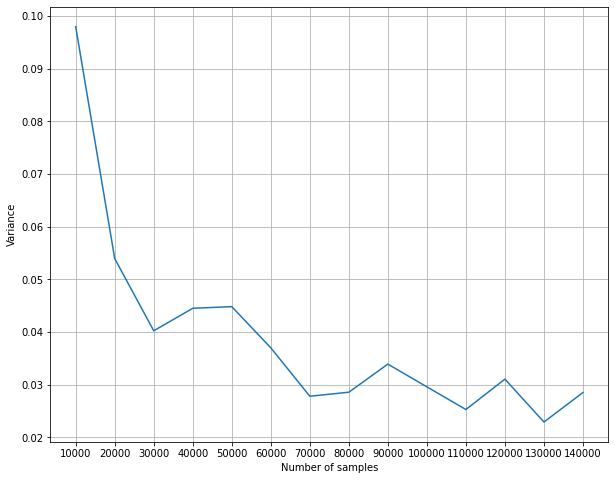

In [ ]:
plot_variance(output, num_samples_list)

In [30]:
#nums_of_existing_datapoints = np.concatenate((np.arange(1, 15), np.arange(15, 46, 3 ), np.arange(46, 150, 7))) #regi feladatbol erkezo pontok szama
#nums_of_existing_datapoints = np.concatenate((np.arange(1, 15), np.arange(15, 50, 3 )))
nums_of_existing_datapoints =np.arange(1, 40, 2)
#nums_new_task =  np.arange(1, 6)   #uj feladatbol erkezo pontok szama
sigma_rewards = np.array([.01]).astype('float32')
#reward_slopes = np.arange(1, 4)
reward_slopes = np.array([1])


n = sigma_rewards.shape[0]
l = nums_of_existing_datapoints.shape[0]
m = reward_slopes.shape[0]
num_new_task = 2

p = tfd.Normal(loc=0, scale=1)
p2 = tfd.Normal(loc=[0, 0], scale=[1, 1])
output_x = np.zeros((n, m, l))
output_x_y = np.zeros((n, m, l))

N_whole = np.max(np.arange(1, 40, 2)).astype('float32')


for i, sigma_reward in enumerate(sigma_rewards):
  for j, reward_slope in enumerate(reward_slopes):
    z_x_whole, r_x_whole = generate_data(N=N_whole, alpha=90, z_prior_type='normal', sigma_z_prior=sigma_z_prior, r_bias=0, sigma_reward=sigma_reward, sigma_bias=0, reward_slope=reward_slope) # x aligned
    z_y = tf.expand_dims(tf.constant([-.2, .7], dtype='float32'), 0)
    r_y = generate_reward(sigma_reward, reward_slope, 0, z_y)
    for  k, N in enumerate(nums_of_existing_datapoints):
      z = tf.concat((z_x_whole[-N:], z_y), axis = 0)
      r = tf.concat((r_x_whole[-N:], r_y), axis = 0)
      num_samples = 300000
      output_x[i, j, k] = tfp.monte_carlo.expectation(
        f=f_x,
        samples=p.sample(num_samples, seed=4245775422))
      output_x_y[i, j, k] = tfp.monte_carlo.expectation(
        f=f_x_y,
        samples=p2.sample(num_samples, seed=42245542))
      print('sigma: %f\n'%sigma_reward)
      print('N: %d\n'%N)
      np.save('output_x.npy', output_x)
      np.save('output_x_y.npy', output_x_y)

tf.Tensor([[-0.1932499]], shape=(1, 1), dtype=float32)
sigma: 0.010000

N: 1

sigma: 0.010000

N: 3

sigma: 0.010000

N: 5

sigma: 0.010000

N: 7

sigma: 0.010000

N: 9

sigma: 0.010000

N: 11

sigma: 0.010000

N: 13

sigma: 0.010000

N: 15

sigma: 0.010000

N: 17

sigma: 0.010000

N: 19

sigma: 0.010000

N: 21

sigma: 0.010000

N: 23

sigma: 0.010000

N: 25

sigma: 0.010000

N: 27

sigma: 0.010000

N: 29

sigma: 0.010000

N: 31

sigma: 0.010000

N: 33

sigma: 0.010000

N: 35

sigma: 0.010000

N: 37

sigma: 0.010000

N: 39



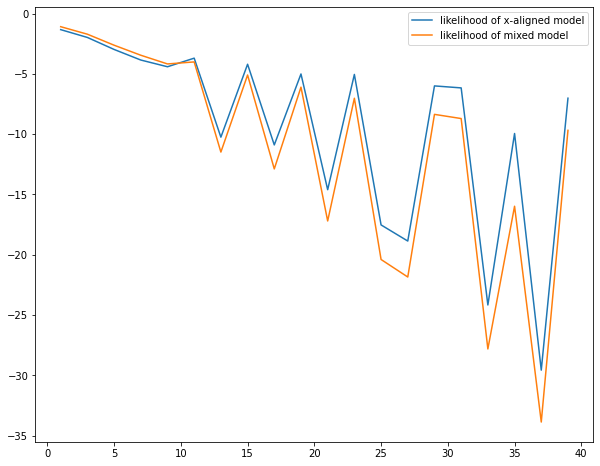

In [31]:
plt.figure(figsize = (10, 8))
ax = plt.gca()
simp = ax.plot(nums_of_existing_datapoints, np.log(output_x[0, 0, :]), label='likelihood of x-aligned model')
diff = ax.plot(nums_of_existing_datapoints, np.log(output_x_y[0, 0, :]), label = 'likelihood of mixed model')
plt.legend()
plt.show()